In [1]:
import glob # library to import multiples .csv files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from Functions import import_PV_WT_data, ExpandSOLETE, TimePeriods, PrepareMLmodel, TestMLmodel, get_results, post_process, PV_Performance_Model # Funções disponibilizadas pelo SOLETE

# Importando os dados da base SOLETE

In [2]:
df_5 = pd.read_hdf("Data/Solete/SOLETE_Pombo_5min.h5")
df_60 = pd.read_hdf("Data/Solete/SOLETE_Pombo_60min.h5")
plt.rcParams["figure.figsize"] = (10,5)

In [3]:
print("Quantidade de medidas",df_5.shape[0])
#print(df_60.shape[0])
print(df_5.columns)
print(df_5.index)
#print(df_5.head())


Quantidade de medidas 131617
Index(['TEMPERATURE[degC]', 'HUMIDITY[%]', 'WIND_SPEED[m1s]', 'WIND_DIR[deg]',
       'GHI[kW1m2]', 'POA Irr[kW1m2]', 'P_Gaia[kW]', 'P_Solar[kW]',
       'Pressure[mbar]'],
      dtype='object')
DatetimeIndex(['2018-06-01 00:00:00', '2018-06-01 00:05:00',
               '2018-06-01 00:10:00', '2018-06-01 00:15:00',
               '2018-06-01 00:20:00', '2018-06-01 00:25:00',
               '2018-06-01 00:30:00', '2018-06-01 00:35:00',
               '2018-06-01 00:40:00', '2018-06-01 00:45:00',
               ...
               '2019-08-31 23:15:00', '2019-08-31 23:20:00',
               '2019-08-31 23:25:00', '2019-08-31 23:30:00',
               '2019-08-31 23:35:00', '2019-08-31 23:40:00',
               '2019-08-31 23:45:00', '2019-08-31 23:50:00',
               '2019-08-31 23:55:00', '2019-09-01 00:00:00'],
              dtype='datetime64[ns]', length=131617, freq=None)


In [4]:
IRR='POA Irr[kW1m2]'
P = 'P_Solar[kW]'

## Dados do Inversor

In [5]:
def import_PV_WT_data():
    """
    Returns
    -------
    PV : dict
        Holds data regarding the PV string in SYSLAB 715
    WT : dict
        Holds data regarding the Gaia wind turbine

    """
    
    PV={
        "Type": "Poly-cristaline",
        "Az": 60,#deg
        "Estc": 1000, #W/m**2
        "Tstc": 25,#C
        'Pmp_stc' : [165, 125], #W
        'ganma_mp' : [-0.478/100, -0.45/100], #1/K
        'Ns':[18, 6], #int
        'Np':[2, 2], #int
        'a' : [-3.56, -3.56], #module material construction parameters a, b and D_T
        'b' : [-0.0750, -0.0750],
        'D_T' : [3, 3],# represents the difference between the module and cell temperature
                        #these three parameters correspond to glass/cell/polymer sheet with open rack
                        #they are extracted from Sandia document King, Boyson form 2004 page 20
        'eff_P' : [[0, 250, 400, 450, 500, 600, 650, 750, 825, 1000, 1200, 1600, 2000, 3000, 4000,  6000, 8000, 10000],
                   [0, 250, 400, 450, 500, 600, 650, 750, 825, 1000, 1200, 1600, 2000, 3000, 4000,  6000, 8000, 10000]],
        'eff_%' : [[0, 85.5, 90.2, 90.9, 91.8, 92, 92.3, 94, 94.4, 94.8, 95.6, 96, 97.3, 97.7, 98, 98.1, 98.05, 98],
                   [0, 85.5, 90.2, 90.9, 91.8, 92, 92.3, 94, 94.4, 94.8, 95.6, 96, 97.3, 97.7, 98, 98.1, 98.05, 98]],
       "index": ['A','B'], #A and B refer to each channel of the inverter, which has connected a different string.
        }
    
    WT={
        "Type": "Asynchronous",
        "Mode": "Passive, downwind vaning",
        "Pn": 11,#kW
        "Vn": 400,#V
        'CWs' : [3.5, 6, 8, 10, 10.5, 11, 12, 13, 13.4, 14, 16, 18, 20, 22, 24, 25,],#m/s
        'CP' : [0, 5, 8.5, 10.9, 11.2, 11.3, 11.2, 10.5, 10.5, 10, 8.8, 8.7, 8, 7.3, 6.6, 6.3,],#kW
        "Cin": 3.5,#m/s
        "Cout": 25,#m/s
        "HH": 18,#m
        "D": 13,#m
        "SA": 137.7,#m**2
        "B": 2,#int       
        }
    
    return PV, WT

In [6]:
PVinfo, WTinfo = import_PV_WT_data()

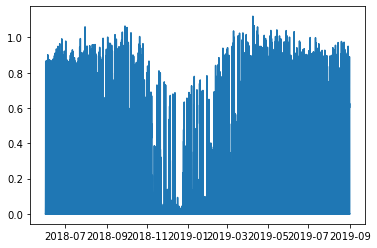

In [7]:
plt.plot(df_5[IRR])

# Limpando os dados

In [8]:
#Removendo valores menor do que 50 kW/m²
selecao = df_5['POA Irr[kW1m2]'] > 0.05
print(df_5.shape[0])
df_5 = df_5[selecao]
print(df_5.shape[0])
print(df_5.head())

131617
49750
                     TEMPERATURE[degC]  HUMIDITY[%]  WIND_SPEED[m1s]  \
2018-06-01 04:25:00          14.700000          0.7         1.062667   
2018-06-01 04:30:00          14.753000          0.7         0.930333   
2018-06-01 04:35:00          14.892333          0.7         1.249333   
2018-06-01 04:40:00          14.803000          0.7         1.438667   
2018-06-01 04:45:00          14.946333          0.7         1.421333   

                     WIND_DIR[deg]  GHI[kW1m2]  POA Irr[kW1m2]  P_Gaia[kW]  \
2018-06-01 04:25:00      75.906667    0.114327        0.050053         0.0   
2018-06-01 04:30:00      87.523333    0.122823        0.053703         0.0   
2018-06-01 04:35:00     101.496667    0.130153        0.055893         0.0   
2018-06-01 04:40:00      91.920000    0.136300        0.057490         0.0   
2018-06-01 04:45:00      98.243333    0.144747        0.058943         0.0   

                     P_Solar[kW]  Pressure[mbar]  
2018-06-01 04:25:00     0.271940  

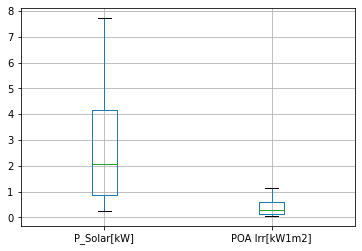

In [9]:
#Verificando outleirs
boxplot = df_5.boxplot(column=[P, IRR])

# Calculando e incluindo os valores de Temperatura do Módulo e PR

In [10]:
Np_a = PVinfo['Np'][0]
Ns_a = PVinfo['Ns'][0]
P_ideal_A = Np_a*Ns_a*200
P_ideal_A

7200

In [11]:
df_5['PR_A'] = df_5[P] / (P_ideal_A * df_5[IRR] / 1000)

In [12]:
#Expandindo o dataset
df_5['Pac'], df_5['Pdc'], df_5['TempModule'], df_5['TempCell'] = PV_Performance_Model(df_5, PVinfo)
df_5.head()


,TEMPERATURE[degC],HUMIDITY[%],WIND_SPEED[m1s],WIND_DIR[deg],GHI[kW1m2],POA Irr[kW1m2],P_Gaia[kW],P_Solar[kW],Pressure[mbar],PR_A,Pac,Pdc,TempModule,TempCell
2018-06-01 04:25:00,14.700000,0.7,1.062667,75.906667,0.114327,0.050053,0.0,0.271940,1016.659998,0.754584,0.380568,0.387939,16.014412,16.164572
2018-06-01 04:30:00,14.753000,0.7,0.930333,87.523333,0.122823,0.053703,0.0,0.289920,1016.746334,0.749798,0.407998,0.415900,16.177328,16.338438
2018-06-01 04:35:00,14.892333,0.7,1.249333,101.496667,0.130153,0.055893,0.0,0.304993,1016.786328,0.757875,0.424310,0.432528,16.339699,16.507379
2018-06-01 04:40:00,14.803000,0.7,1.438667,91.920000,0.136300,0.057490,0.0,0.316803,1016.860010,0.765359,0.436558,0.445014,16.270721,16.443191
2018-06-01 04:45:00,14.946333,0.7,1.421333,98.243333,0.144747,0.058943,0.0,0.330323,1016.906356,0.778345,0.447215,0.455877,16.453116,16.629946


# Inserindo "falhas" em uma semana do periodo observado

In [13]:
#Separando uma semana especifico
selecao_semana = (df_5.index >= "2019-06-10 00:00:00") & (df_5.index <= "2019-06-16 23:59:59")
semana1 = df_5[selecao_semana]

#Introduzindo a falha nesse dia
semana1[P] = semana1[P]* 0.7  #70% dos valores que seriam os valores padrões
#Introduzindo novamente ao dataset
df_5[P].update(semana1[P])

C:\Users\Bruno\AppData\Local\Temp\ipykernel_21000\1589596243.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  semana1[P] = semana1[P]* 0.7  #70% dos valores que seriam os valores padrões


# Visualizando dados de 5 min

In [14]:
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams.update({'font.size': 22})

In [15]:
#importando e definindo a função necessária para calcular r²
from scipy import stats
def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return r_value**2

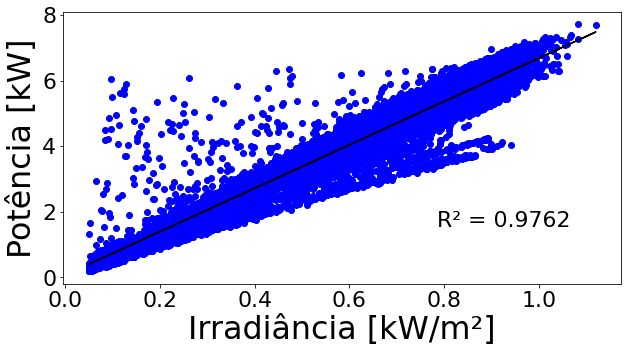

R-square =  0.976167636844358


In [16]:
#Plotando um gráfico scatter de todos os dias com uma fit line e o R²
plt.scatter(df_5[IRR],df_5[P], color = "blue")
plt.xlabel("Irradiância [kW/m²]", fontsize='x-large')
plt.ylabel("Potência [kW]", fontsize='x-large')

a, b = np.polyfit(df_5[IRR],df_5[P], 1) #Encontrando a melhor fit line (R²) entre os dois valores
plt.plot(df_5[IRR], a*df_5[IRR]+b, color = "black",)
r2 = rsquared(df_5[IRR],df_5[P])
plt.text(0.7*df_5[IRR].max(), 0.2*df_5[P].max(), 'R² = %0.4f' % r2, color = "black")
#plt.title("Gráfico dos dados \"crus\" de 5 minutos")
plt.savefig('images/DadosNTratados.png')
plt.show()

print("R-square = ", r2)

## Removendo falhas

In [17]:
limite_sup = 0.1 #Atribuindo um valor de 0.5kW acima e abaixo da fit line para valores de falha
limite_inf = 0.1
selecao_erros = (df_5[P] > (a+2)*df_5[IRR]+b + limite_sup) | (df_5[P] < (a-1.5)*df_5[IRR]+b - limite_inf) | (df_5.index >= "2018-06-10 00:00:00") & (df_5.index <= "2018-06-11 23:59:59")
df_5_f = df_5[selecao_erros]

df_5_nf = df_5[~selecao_erros] 

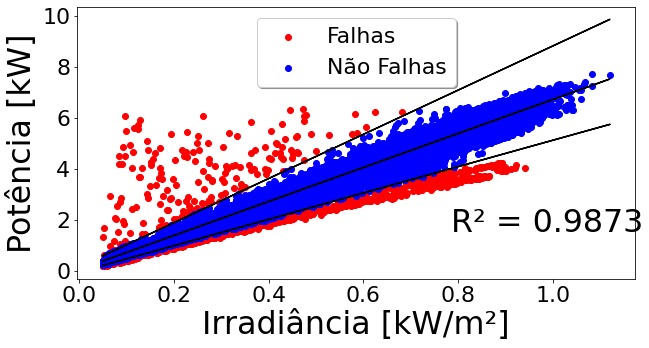

In [18]:
#plotando os valores dentro e fora da faixa definida
plt.scatter(df_5_f[IRR],df_5_f[P], color = "red", label = "Falhas")
plt.scatter(df_5_nf[IRR],df_5_nf[P], color = 'blue', label = "Não Falhas")
plt.xlabel("Irradiância [kW/m²]", fontsize='x-large')
plt.ylabel("Potência [kW]", fontsize='x-large')

a, b = np.polyfit(df_5_nf[IRR],df_5_nf[P], 1) #Encontrando a melhor fit line entre os dois valores
plt.plot(df_5_nf[IRR], a*df_5_nf[IRR]+b, color = "black",) #Plotando no gráfico a fit line
plt.plot(df_5_nf[IRR], (a+2)*df_5_nf[IRR]+(b+0.1), color = "black",) #Limite Superior
plt.plot(df_5_nf[IRR], (a-1.5)*df_5_nf[IRR]+(b-0.1), color = "black",) #Limite Inferior
r2 = rsquared(df_5_nf[IRR],df_5_nf[P])
plt.text(0.7*df_5_nf[IRR].max(), 0.2*df_5_nf[P].max(), 'R² = %0.4f' % r2, color = "black", fontsize='x-large')


plt.legend(loc='upper center', shadow=True)
#plt.title("Dados de 5 minutos com a detecção visual de falhas e não falhas")
plt.savefig('images/VisualFaultswf.png')
plt.show()


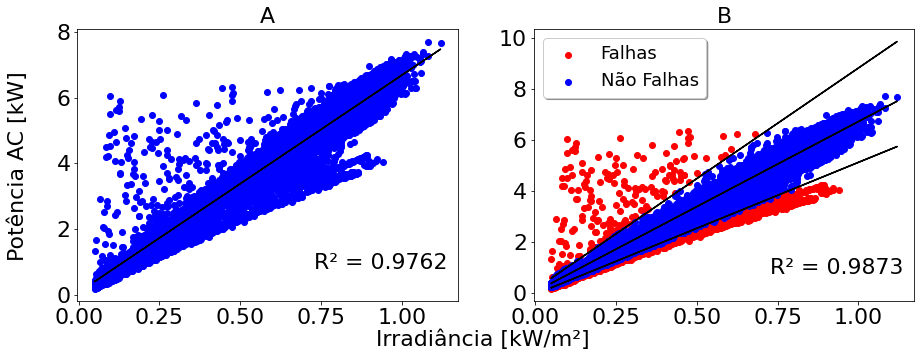

In [19]:
# Plotando a detecção de falhas usando a média e desvio padrão
plt.rcParams["figure.figsize"] = [15, 5]
fig = plt.figure()

ax1 = plt.subplot(121)
ax1.scatter(df_5[IRR],df_5[P], color = "blue")
a, b = np.polyfit(df_5[IRR],df_5[P], 1) #Encontrando a melhor fit line (R²) entre os dois valores
ax1.plot(df_5[IRR], a*df_5[IRR]+b, color = "black",)
r2 = rsquared(df_5[IRR],df_5[P])
ax1.text(0.65*df_5[IRR].max(), 0.1*df_5[P].max(), 'R² = %0.4f' % r2, color = "black")
ax1.set_title('A', fontsize = '22')

ax2 = plt.subplot(122)
ax2.scatter(df_5_f[IRR],df_5_f[P], color = "red", label = "Falhas")
ax2.scatter(df_5_nf[IRR],df_5_nf[P], color = 'blue', label = "Não Falhas")
ax2.legend(loc='upper left', shadow=True, fontsize = "18")
a, b = np.polyfit(df_5_nf[IRR],df_5_nf[P], 1) #Encontrando a melhor fit line entre os dois valores
ax2.plot(df_5_nf[IRR], a*df_5_nf[IRR]+b, color = "black",) #Plotando no gráfico a fit line
ax2.plot(df_5_nf[IRR], (a+2)*df_5_nf[IRR]+(b+0.1), color = "black",) #Limite Superior
ax2.plot(df_5_nf[IRR], (a-1.5)*df_5_nf[IRR]+(b-0.1), color = "black",) #Limite Inferior
r2 = rsquared(df_5_nf[IRR],df_5_nf[P])
ax2.text(0.65*df_5_nf[IRR].max(), 0.1*df_5_nf[P].max(), 'R² = %0.4f' % r2, color = "black")
ax2.set_title('B', fontsize = '22')

fig.text(0.5, 0.0005, 'Irradiância [kW/m²]', ha='center')
fig.text(0.06, 0.5, 'Potência AC [kW]', va='center', rotation='vertical')

plt.savefig('images/visufaults5min.png')
plt.show()

In [20]:
print("Falhas = ",df_5_f.shape[0])
print("Não Falhas = ",df_5_nf.shape[0])

Falhas =  1487
Não Falhas =  48263


# Visualizando com ajuda da função resample o gráfico dos dados médios por hora

In [21]:
df_resample_60 = df_5.resample("1H").mean()
df_resample_60[P].isna().sum()


6266

In [22]:
#retirando valores NaN
print(df_resample_60.shape[0])
df_resample_60.dropna(inplace = True)
print(df_resample_60.shape[0])

10958
4692


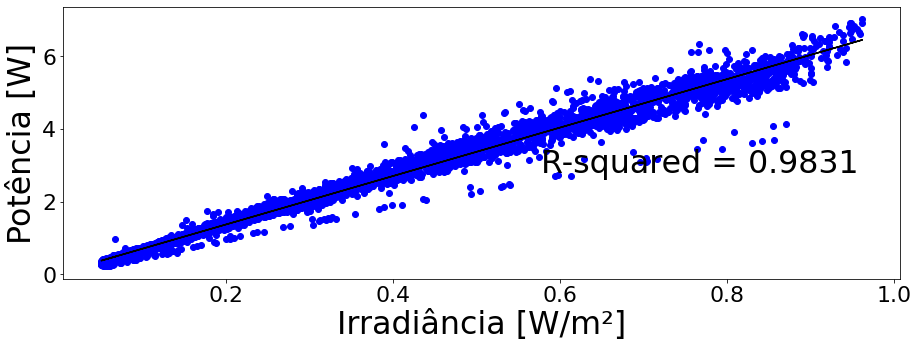

R-square =  0.9831134409921596


In [23]:
#Plotando um gráfico scatter de todos os dias com uma fit line e o R²
plt.scatter(df_resample_60[IRR],df_resample_60[P], color = "blue")
plt.xlabel("Irradiância [W/m²]", fontsize='x-large')
plt.ylabel("Potência [W]", fontsize='x-large')

a, b = np.polyfit(df_resample_60[IRR],df_resample_60[P], 1) #Encontrando a melhor fit line (R²) entre os dois valores
plt.plot(df_resample_60[IRR], a*df_resample_60[IRR]+b, color = "black",)
r2 = rsquared(df_resample_60[IRR],df_resample_60[P])
plt.text(0.6*df_resample_60[IRR].max(), 0.4*df_resample_60[P].max(), 'R-squared = %0.4f' % r2, color = "black", fontsize='x-large')
plt.savefig('images/DadosNTratados1h.png')
plt.show()

print("R-square = ", r2)

In [24]:
print(a)
print(b)

6.669160364416062
0.042583073436135745


## Removendo Falhas da medida de 1hora

In [25]:
#Calculando a medida de potência dividia por potência estimulada para uso futuro
df_resample_60['P/Pac'] = df_resample_60[P]/ df_resample_60['Pac']
#df_resample_60.to_csv('Data/Solete/PorHoraComFalha.csv')

In [26]:
limite_sup = 0.1 #Atribuindo um valor de 0.5kW acima e abaixo da fit line para valores de falha
limite_inf = 0.1
selecao_erros = (df_resample_60[P] > (a+2)*df_resample_60[IRR]+b + limite_sup) | (df_resample_60[P] < (a-1.5)*df_resample_60[IRR]+b - limite_inf) | (df_resample_60.index >= "2019-06-10 00:00:00") & (df_resample_60.index <= "2019-06-16 23:59:59")
df_resample_60_f = df_resample_60[selecao_erros]

df_resample_60_nf = df_resample_60[~selecao_erros] 

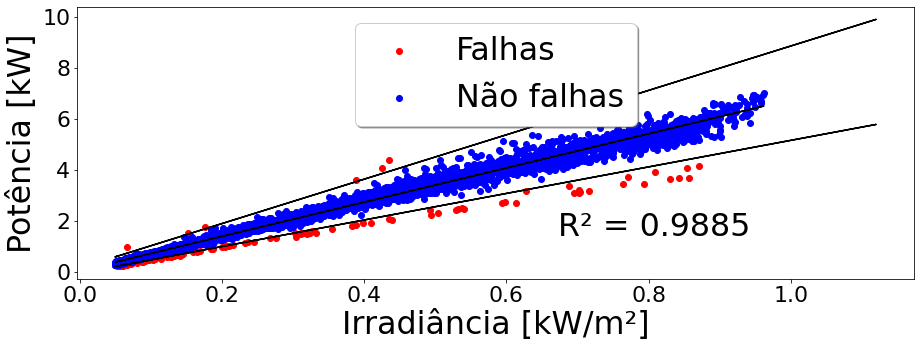

In [27]:
#plotando os valores dentro e fora da faixa definida
plt.scatter(df_resample_60_f[IRR],df_resample_60_f[P], color = "red", label = "Falhas")
plt.scatter(df_resample_60_nf[IRR],df_resample_60_nf[P], color = 'blue', label = 'Não falhas')
plt.xlabel("Irradiância [kW/m²]", fontsize='x-large')
plt.ylabel("Potência [kW]", fontsize='x-large')

#Retas 
a, b = np.polyfit(df_resample_60_nf[IRR],df_resample_60_nf[P], 1) #Encontrando a melhor fit line entre os dois valores
plt.plot(df_resample_60_nf[IRR], a*df_resample_60_nf[IRR]+b, color = "black") #Plotando no gráfico a fit line
plt.plot(df_5_nf[IRR], (a+2)*df_5_nf[IRR]+(b+0.1), color = "black") #Limite Superior
plt.plot(df_5_nf[IRR], (a-1.5)*df_5_nf[IRR]+(b-0.1), color = "black") #Limite Inferior



#R-squared
r2 = rsquared(df_resample_60_nf[IRR],df_resample_60_nf[P])
plt.text(0.7*df_resample_60_nf[IRR].max(), 0.2*df_resample_60_nf[P].max(), 'R² = %0.4f' % r2, color = "black", fontsize='x-large')


plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.savefig('images/visualfaults1hwf.png')
#plt.title("Potência x IRR em valores médios de 1 em 1 hora")
plt.show()

In [28]:
print("Falhas = ",df_resample_60_f.shape[0])
print("Não Falhas = ",df_resample_60_nf.shape[0])

Falhas =  101
Não Falhas =  4591


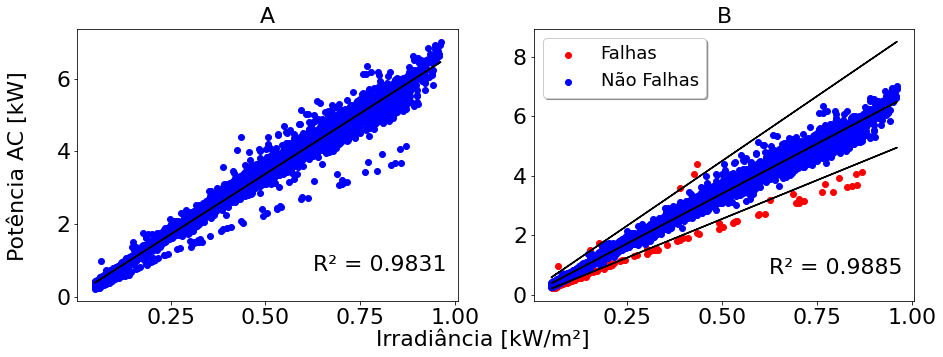

In [29]:
# Plotando a detecção de falhas usando a média e desvio padrão
plt.rcParams["figure.figsize"] = [15, 5]
fig = plt.figure()

ax1 = plt.subplot(121)
ax1.scatter(df_resample_60[IRR],df_resample_60[P], color = "blue")
a, b = np.polyfit(df_resample_60[IRR],df_resample_60[P], 1) #Encontrando a melhor fit line (R²) entre os dois valores
ax1.plot(df_resample_60[IRR], a*df_resample_60[IRR]+b, color = "black",)
r2 = rsquared(df_resample_60[IRR],df_resample_60[P])
ax1.text(0.65*df_resample_60[IRR].max(), 0.1*df_resample_60[P].max(), 'R² = %0.4f' % r2, color = "black")
ax1.set_title('A', fontsize = '22')

ax2 = plt.subplot(122)
ax2.scatter(df_resample_60_f[IRR],df_resample_60_f[P], color = "red", label = "Falhas")
ax2.scatter(df_resample_60_nf[IRR],df_resample_60_nf[P], color = 'blue', label = "Não Falhas")
ax2.legend(loc='upper left', shadow=True, fontsize = "18")
a, b = np.polyfit(df_resample_60_nf[IRR],df_resample_60_nf[P], 1) #Encontrando a melhor fit line entre os dois valores
ax2.plot(df_resample_60_nf[IRR], a*df_resample_60_nf[IRR]+b, color = "black",) #Plotando no gráfico a fit line
ax2.plot(df_resample_60_nf[IRR], (a+2)*df_resample_60_nf[IRR]+(b+0.1), color = "black",) #Limite Superior
ax2.plot(df_resample_60_nf[IRR], (a-1.5)*df_resample_60_nf[IRR]+(b-0.1), color = "black",) #Limite Inferior
r2 = rsquared(df_resample_60_nf[IRR],df_resample_60_nf[P])
ax2.text(0.65*df_resample_60_nf[IRR].max(), 0.1*df_resample_60_nf[P].max(), 'R² = %0.4f' % r2, color = "black")
ax2.set_title('B', fontsize = '22')

fig.text(0.5, 0.0005, 'Irradiância [kW/m²]', ha='center')
fig.text(0.06, 0.5, 'Potência AC [kW]', va='center', rotation='vertical')

plt.savefig('images/visufaults1h.png')
plt.show()

# PR semanal

In [30]:
df_resample_1W = df_5.resample("W").sum()


print(df_resample_1W[IRR].isna().sum())
df_resample_1W[29:31]


0


,TEMPERATURE[degC],HUMIDITY[%],WIND_SPEED[m1s],WIND_DIR[deg],GHI[kW1m2],POA Irr[kW1m2],P_Gaia[kW],P_Solar[kW],Pressure[mbar],PR_A,Pac,Pdc,TempModule,TempCell
2018-12-23,0.000000,0.000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-12-30,1066.187333,188.343,1054.990667,62041.936667,15.943967,53.46533,1164.703473,391.597332,221271.610746,214.994462,409.430413,417.360258,2153.015247,2313.411237


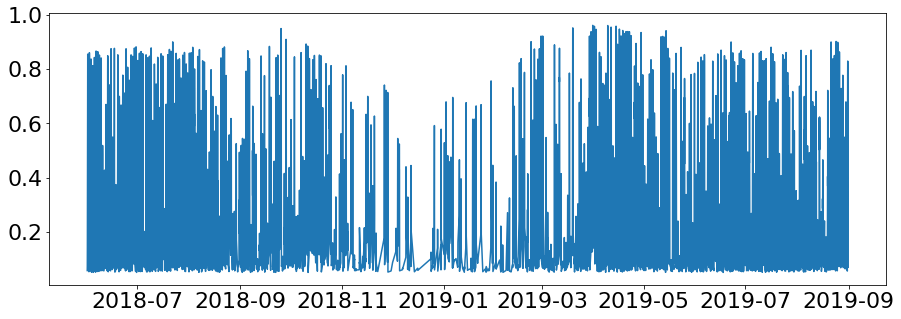

In [31]:
plt.rcParams["figure.figsize"] = [15, 5]
plt.plot(df_resample_60[IRR])

plt.savefig('images/IRRsemanal.png', bbox_inches="tight")
plt.show()

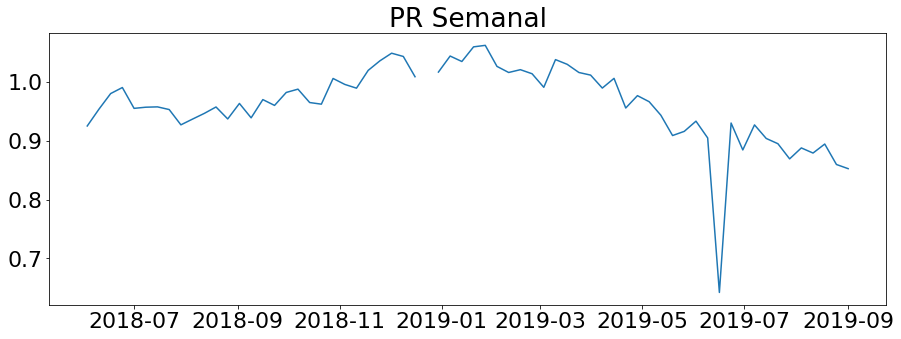

In [32]:

df_resample_1W['PR_A1'] = df_resample_1W[P] / (7200 * df_resample_1W[IRR] / 1000)
plt.title("PR Semanal")
plt.plot(df_resample_1W['PR_A1'])

plt.savefig('images/PRsemanal.png', bbox_inches="tight")
plt.show()


# Extraindo dados de média, desvio padrão dos dados com todas as irradiâncias

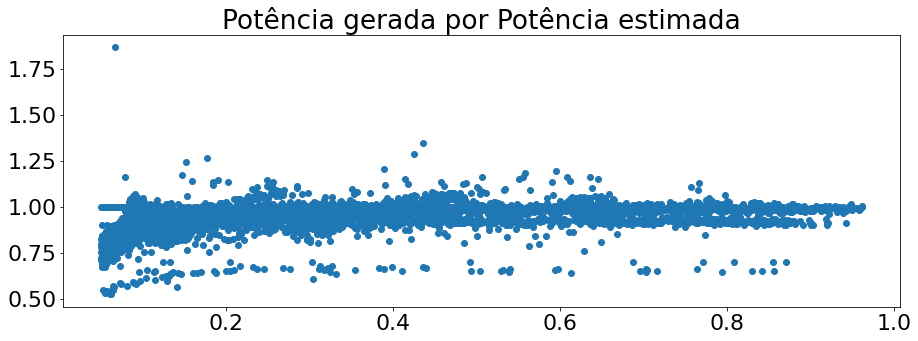

In [33]:
plt.title("Potência gerada por Potência estimada")
plt.scatter(df_resample_60[IRR],df_resample_60['P/Pac'])

In [34]:
media_1h = df_resample_60['P/Pac'].mean()
desvio_padrao_1h = df_resample_60['P/Pac'].std()
print(desvio_padrao_1h)
print(media_1h)


0.08900086194010597
0.9258063229544878


## Selecionando os valores falhos média +- 3 desvios padrões

In [35]:
selecao_falhas = (df_resample_60['P/Pac'] >= (media_1h + 3*desvio_padrao_1h))  | (df_resample_60['P/Pac'] <= (media_1h - 3*desvio_padrao_1h))
df_60_falhas = df_resample_60[selecao_falhas]
df_60_nfalhas = df_resample_60[~selecao_falhas]
df_60_falhas.shape[0]

70

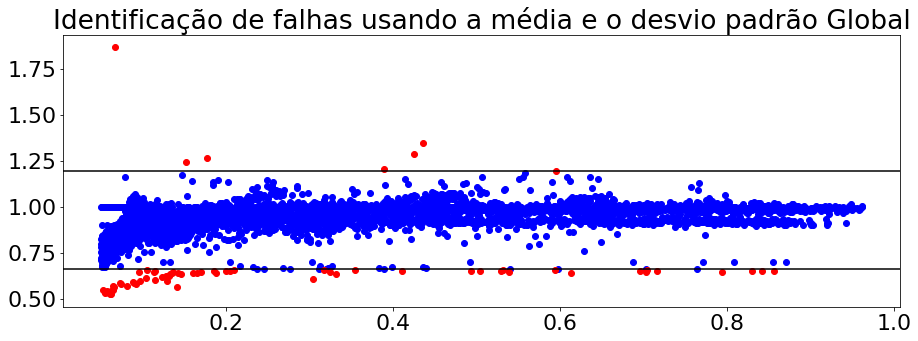

In [36]:
plt.scatter(df_60_nfalhas[IRR],df_60_nfalhas['P/Pac'], color = 'blue')
plt.scatter(df_60_falhas[IRR],df_60_falhas['P/Pac'], color = 'red')
plt.axhline(y=(media_1h + 3*desvio_padrao_1h), color='black', linestyle='-')
plt.axhline(y=(media_1h - 3*desvio_padrao_1h), color='black', linestyle='-')
plt.title("Identificação de falhas usando a média e o desvio padrão Global")
plt.show()

# Dividindo os gráficos em 3 faixas de irradiância 50-250, 250-500, 500-max

4692
2274
1119
1299


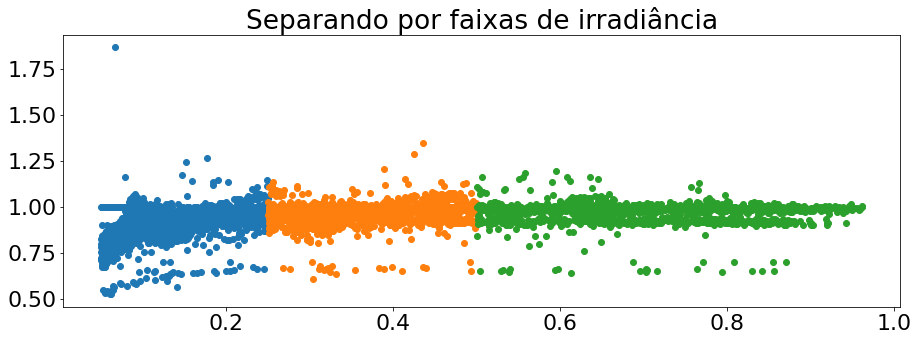

In [37]:
selecao_faixa1 = (df_resample_60[IRR] >= 50/1000) & (df_resample_60[IRR] <= 250/1000)
selecao_faixa2 = (df_resample_60[IRR] > 250/1000) & (df_resample_60[IRR] <= 500/1000)
selecao_faixa3 = (df_resample_60[IRR] > 500/1000)

df_faixa1 = df_resample_60[selecao_faixa1]
df_faixa2 = df_resample_60[selecao_faixa2]
df_faixa3 = df_resample_60[selecao_faixa3]

print(df_resample_60.shape[0])
print(df_faixa1.shape[0])
print(df_faixa2.shape[0])
print(df_faixa3.shape[0])

plt.scatter(df_faixa1[IRR],df_faixa1['P/Pac'])
plt.scatter(df_faixa2[IRR],df_faixa2['P/Pac'])
plt.scatter(df_faixa3[IRR],df_faixa3['P/Pac'])
plt.title("Separando por faixas de irradiância")
plt.show()



In [38]:
media_f1 = df_faixa1['P/Pac'].mean()
desvio_padrao_f1 = df_faixa1['P/Pac'].std()

media_f2 = df_faixa2['P/Pac'].mean()
desvio_padrao_f2 = df_faixa2['P/Pac'].std()

media_f3 = df_faixa3['P/Pac'].mean()
desvio_padrao_f3 = df_faixa3['P/Pac'].std()

## Separando medidas falhas de cada faixa

In [39]:
# Faixa 1
selecao_falhas = (df_faixa1['P/Pac'] >= (media_f1 + 3*desvio_padrao_f1))  | (df_faixa1['P/Pac'] <= (media_f1 - 3*desvio_padrao_f1))
df_faixa1_f = df_faixa1[selecao_falhas]
df_faixa1_nf = df_faixa1[~selecao_falhas]
df_faixa1_f.shape[0]

26

In [40]:
# Faixa 2
selecao_falhas = (df_faixa2['P/Pac'] >= (media_f2 + 3*desvio_padrao_f2))  | (df_faixa2['P/Pac'] <= (media_f2 - 3*desvio_padrao_f2))
df_faixa2_f = df_faixa2[selecao_falhas]
df_faixa2_nf = df_faixa2[~selecao_falhas]
df_faixa2_f.shape[0]

24

In [41]:
# Faixa 3
selecao_falhas = (df_faixa3['P/Pac'] >= (media_f3 + 3*desvio_padrao_f3))  | (df_faixa3['P/Pac'] <= (media_f3 - 3*desvio_padrao_f3))
df_faixa3_f = df_faixa3[selecao_falhas]
df_faixa3_nf = df_faixa3[~selecao_falhas]
df_faixa3_f.shape[0]

32

[]

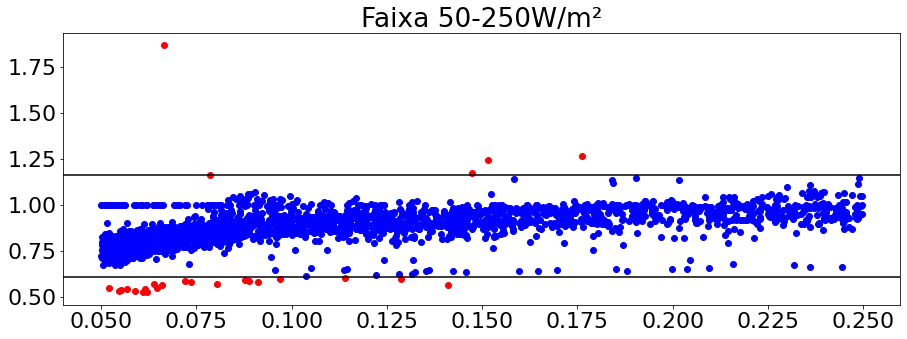

In [42]:
#Printando apenas a primeira faixa 50-250
plt.scatter(df_faixa1_nf[IRR],df_faixa1_nf['P/Pac'], color = 'blue')
plt.scatter(df_faixa1_f[IRR],df_faixa1_f['P/Pac'], color = 'red')
plt.axhline(y=(media_f1 + 3*desvio_padrao_f1), color='black', linestyle='-', xmax = 1)
plt.axhline(y=(media_f1 - 3*desvio_padrao_f1), color='black', linestyle='-', xmax = 1)
plt.title("Faixa 50-250W/m²")
plt.plot()


[]

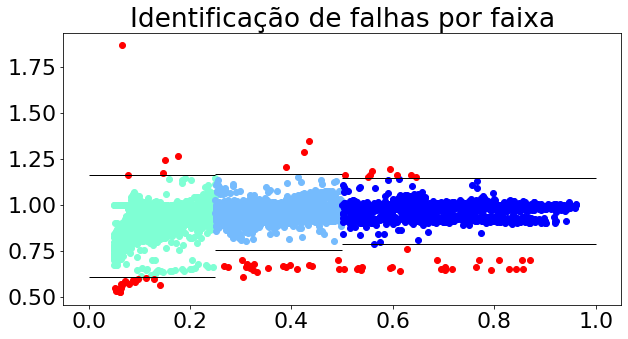

In [43]:
plt.rcParams["figure.figsize"] = (10,5)

plt.scatter(df_faixa1_nf[IRR],df_faixa1_nf['P/Pac'], color = 'aquamarine')
plt.scatter(df_faixa1_f[IRR],df_faixa1_f['P/Pac'], color = 'red')
plt.subplot().hlines(y=(media_f1 + 3*desvio_padrao_f1), xmin=0, xmax=0.250, linewidth=1, color='black')
plt.subplot().hlines(y=(media_f1 - 3*desvio_padrao_f1), xmin=0, xmax=0.250, linewidth=1, color='black')

plt.scatter(df_faixa2_nf[IRR],df_faixa2_nf['P/Pac'], color = 'xkcd:sky blue')
plt.scatter(df_faixa2_f[IRR],df_faixa2_f['P/Pac'], color = 'red')
plt.subplot().hlines(y=(media_f2 + 3*desvio_padrao_f2), xmin=0.250, xmax=0.5, linewidth=1, color='black')
plt.subplot().hlines(y=(media_f2 - 3*desvio_padrao_f2), xmin=0.250, xmax=0.5, linewidth=1, color='black')

plt.scatter(df_faixa3_nf[IRR],df_faixa3_nf['P/Pac'], color = 'blue')
plt.scatter(df_faixa3_f[IRR],df_faixa3_f['P/Pac'], color = 'red')
plt.subplot().hlines(y=(media_f3 + 3*desvio_padrao_f3), xmin=0.5,xmax = 1, linewidth=1, color='black')
plt.subplot().hlines(y=(media_f3 - 3*desvio_padrao_f3), xmin=0.5,xmax = 1, linewidth=1, color='black')
plt.title("Identificação de falhas por faixa")
plt.plot()

## Imprimindo somente as falhas verificadas "visualmente"

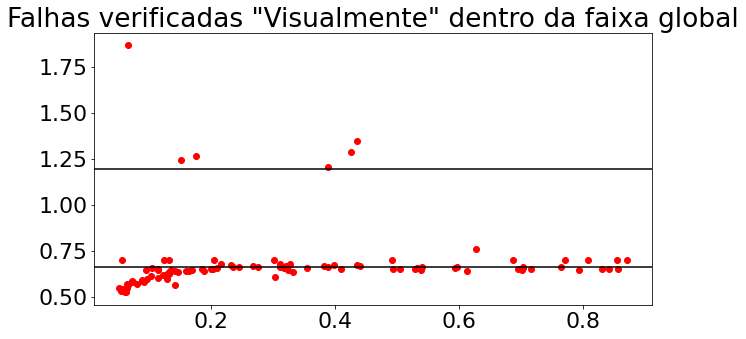

In [44]:
#Imprimindo somente as falhas com os limites superiores e inferiores
#plt.scatter(df_resample_60_f[IRR],df_resample_60_f['P/Pac'], color = 'blue')
plt.rcParams["figure.figsize"] = (10,5)
plt.scatter(df_resample_60_f[IRR],df_resample_60_f['P/Pac'], color = 'red')
plt.axhline(y=(media_1h + 3*desvio_padrao_1h), color='black', linestyle='-')
plt.axhline(y=(media_1h - 3*desvio_padrao_1h), color='black', linestyle='-')
plt.title("Falhas verificadas \"Visualmente\" dentro da faixa global")
plt.show()

[]

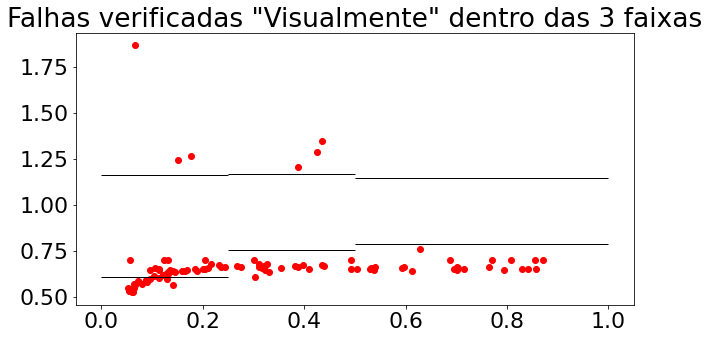

In [45]:
plt.rcParams["figure.figsize"] = (10,5)

plt.scatter(df_resample_60_f[IRR],df_resample_60_f['P/Pac'], color = 'red')
plt.subplot().hlines(y=(media_f1 + 3*desvio_padrao_f1), xmin=0, xmax=0.250, linewidth=1, color='black')
plt.subplot().hlines(y=(media_f1 - 3*desvio_padrao_f1), xmin=0, xmax=0.250, linewidth=1, color='black')


plt.subplot().hlines(y=(media_f2 + 3*desvio_padrao_f2), xmin=0.250, xmax=0.5, linewidth=1, color='black')
plt.subplot().hlines(y=(media_f2 - 3*desvio_padrao_f2), xmin=0.250, xmax=0.5, linewidth=1, color='black')


plt.subplot().hlines(y=(media_f3 + 3*desvio_padrao_f3), xmin=0.5,xmax = 1, linewidth=1, color='black')
plt.subplot().hlines(y=(media_f3 - 3*desvio_padrao_f3), xmin=0.5,xmax = 1, linewidth=1, color='black')
plt.title("Falhas verificadas \"Visualmente\" dentro das 3 faixas")

plt.plot()

## Imprimindo as não falhas para verificar falsos positivos

Text(0.5, 1.0, 'Não falhas verificadas "Visualmente" dentro da faixa global')

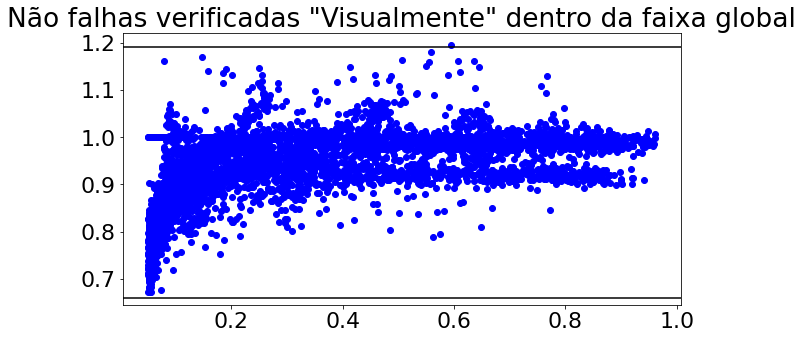

In [46]:
plt.rcParams["figure.figsize"] = (10,5)
plt.scatter(df_resample_60_nf[IRR],df_resample_60_nf['P/Pac'], color = 'blue')
plt.axhline(y=(media_1h + 3*desvio_padrao_1h), color='black', linestyle='-')
plt.axhline(y=(media_1h - 3*desvio_padrao_1h), color='black', linestyle='-')
plt.title("Não falhas verificadas \"Visualmente\" dentro da faixa global")

Text(0.5, 1.0, 'Não Falhas verificadas "Visualmente" dentro das 3 faixas')

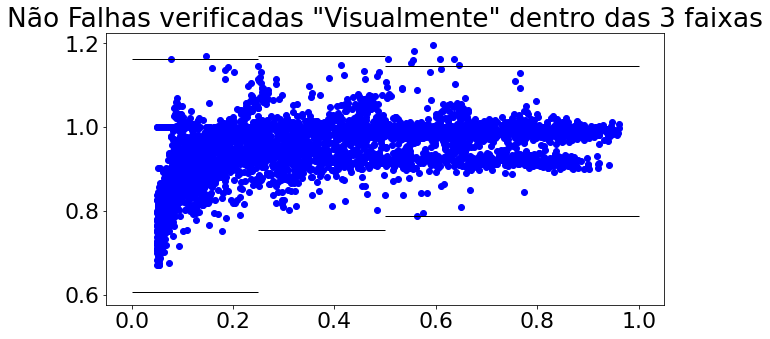

In [47]:
plt.rcParams["figure.figsize"] = (10,5)

plt.scatter(df_resample_60_nf[IRR],df_resample_60_nf['P/Pac'], color = 'blue')
plt.subplot().hlines(y=(media_f1 + 3*desvio_padrao_f1), xmin=0, xmax=0.250, linewidth=1, color='black')
plt.subplot().hlines(y=(media_f1 - 3*desvio_padrao_f1), xmin=0, xmax=0.250, linewidth=1, color='black')


plt.subplot().hlines(y=(media_f2 + 3*desvio_padrao_f2), xmin=0.250, xmax=0.5, linewidth=1, color='black')
plt.subplot().hlines(y=(media_f2 - 3*desvio_padrao_f2), xmin=0.250, xmax=0.5, linewidth=1, color='black')


plt.subplot().hlines(y=(media_f3 + 3*desvio_padrao_f3), xmin=0.5,xmax = 1, linewidth=1, color='black')
plt.subplot().hlines(y=(media_f3 - 3*desvio_padrao_f3), xmin=0.5,xmax = 1, linewidth=1, color='black')

plt.title("Não Falhas verificadas \"Visualmente\" dentro das 3 faixas")

In [48]:
#Limite Global superior
df_resample_60["LimiteSup"] = (media_1h + 3*desvio_padrao_1h)*df_resample_60['Pac']

#Limite Global Inferior
df_resample_60["LimiteInf"] = (media_1h - 3*desvio_padrao_1h)*df_resample_60['Pac']

In [49]:
#Printando os dados de X dias para visualizar so limites
selecao_semana = (df_resample_60.index >= "2019-05-10 00:00:00") & (df_resample_60.index <= "2019-05-13 23:59:59")
dias = df_resample_60[selecao_semana]


Text(0.5, 1.0, 'AC power medido e os limites normais de operação segundo a média e a variância')

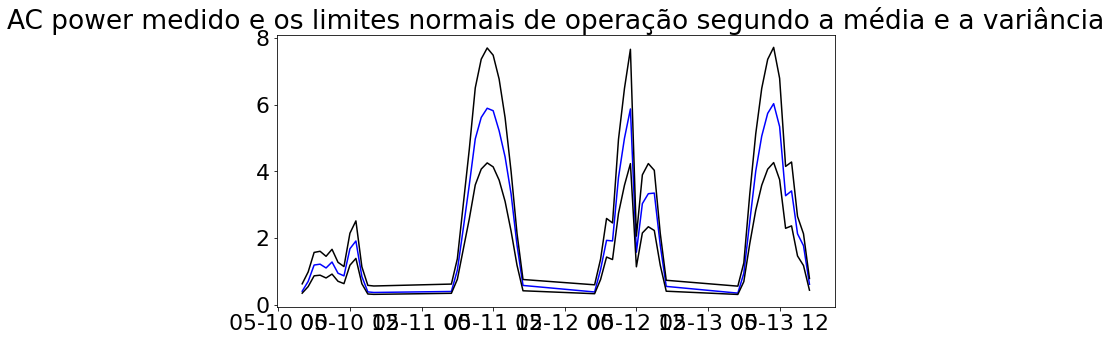

In [50]:
plt.plot(dias[P],color = 'blue')
plt.plot(dias["LimiteSup"],color = 'black')
plt.plot(dias["LimiteInf"],color = 'black')
plt.title("AC power medido e os limites normais de operação segundo a média e a variância")